# NTDS - Project 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.spatial.distance import pdist, squareform
from scipy import stats

%matplotlib inline

## Table of content

1. [Introduction](#intro)
2. [Data acquisition](#acquisition) <br>
    2.1 [Genotype](#genotype) <br>
    2.2 [Phenotype](#phenotype) <br>
    2.3 [Expression data](#expression) <br>
    2.4 [Others](#others) <br>
3. [Data exploration](#exploration) <br>
    3.1 [Genotype network](#genotype_net) <br>
    3.2 [Phenotype network](#phenotype_net) <br>
    3.3 [Expression data network](#expression_net) <br>
3. [Exploitation](#exploitation) <br>

## 1. Introduction
<a id='intro'></a>

|          | Description                                                  |         Amount |
| -------- | ------------------------------------------------------------ | -------------: |
| nodes    | mice                                                         |      100 - 200 |
| edges    | similar genes, protein expressions, or phenotypes            | O(10) per node |
| features | genes, protein expressions in tissues, or phenotypes         |          1000s |
| labels   | depends: a particular gene, phenotype, or protein expression |            N/A |

## 2. Data acquisition
<a id='acquisition'></a>

>Each column is a single BXD strain (a mouse) whose genome is a unique combination of the C57BL/6J and DBA/2J parental strains.

In [2]:
data_folder = './data/BXD data-3/'

### 2.1 Genotype
<a id='genotype'></a>

>The ``genotype_BXD.txt`` file is a binary matrix that describes the contribution of each of the parental strains for a list of selected genes (rows). Each row of the genotype data indicates whether a certain position in the genome is inherited from the C57BL/6J or DBA/2J parent.

In [3]:
df_genotype = pd.read_csv(data_folder + 'genotype_BXD.txt', delimiter ="\t", index_col='SNP').transpose()
df_genotype.index.name = 'BDX_strain'
print(df_genotype.shape)
df_genotype.head()

(97, 7324)


SNP,rs31443144,rs6269442,rs32285189,rs258367496,rs32430919,rs36251697,rs30658298,rs51852623,rs31879829,rs36742481,...,rs47382998,rs13484107,rs3693969,DXMit223,rs31638776,rs31639754,rs46326766,rs31412493,rs31417520,UT-M-9461
BDX_strain,,,,,,,,,,,,,,,,,,,,,
B6D2F1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,-1
D2B6F1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-1,-1,-1,1
C57BL.6J,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
DBA.2J,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
BXD1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,1,1,-1


### 2.2 Phenotype
<a id='phenotype'></a>

>Phenotype data contained in ``Phenotype.txt`` are also matrices indicating the values of each phenotype for each strain.

In [4]:
df_phenotype = pd.read_csv(data_folder + "Phenotype.txt", delimiter="\t", index_col='PhenoID').transpose() 
df_phenotype.index.name = 'BXD_strain'
print(df_phenotype.shape)
df_phenotype.head(5)

(97, 5092)


PhenoID,X3063,X3352,X1093,X2256,X830,X1516,X2451,X3938,X1892,X908,...,X794,X1245,X2048,X502,X2307,X1827,X1149,X3873,X35,X57
BXD_strain,,,,,,,,,,,,,,,,,,,,,
B6D2F1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.894,NaN
D2B6F1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C57BL.6J,1254.09,724.205,887.5,607.708,35444.0,26784.0,13018.0,9457.0,4764.0,2704.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.22,47.847,NaN
DBA.2J,NaN,NaN,507.4,460.070,25325.0,22411.0,2792.0,4354.0,4471.0,4114.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158.28,52.500,NaN
BXD1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4032.0,3366.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.3 Expression data
<a id='expression'></a>

>In addition, multiomic molecular phenotypes from different mouse organs are represented as one matrix per organ (e.g., brain, bone, muscle, liver, etc.), in the ``expression_data`` folder.

In [5]:
def open_expression_data(folder, txt_file):
    expression_data = pd.read_csv(folder + txt_file + '.txt', delimiter ="\t", index_col='gene').transpose()
    expression_data.index.name = 'BXD_strain'
    
    return expression_data

In [6]:
expression_data_folder = data_folder + '/expression data/'

In [7]:
adrenal_female = open_expression_data(expression_data_folder, 'Adrenal_Female')
print(adrenal_female.shape)
adrenal_female.head()

(50, 25613)


gene,Nmt1_10338077,Psmb5_10338095,Hdac5_10338098,Dlg1_10338109,Wars_10338116,Psph_10338122,Copa_10338123,Tbl3_10338144,Gbf1_10338168,Polr2f_10338173,...,Defa-rs7_10608643,Defacr_10608653,Hjurp_10608671,Defa-rs2_10608688,rRNA_10608690,rRNA_10608691,Pdia4_10608692,Rn5s_10608693,Prkcg_10608705,Kdelr2_10608708
BXD_strain,,,,,,,,,,,,,,,,,,,,,
B6D2F1,12.032,13.556,9.238,7.332,10.890,5.092,10.124,8.632,9.258,8.277,...,8.762,8.512,9.057,7.274,14.632,14.626,11.419,8.013,7.566,11.703
C57BL.6J,11.739,13.179,8.870,8.543,10.911,6.153,9.971,8.430,9.690,8.713,...,8.730,8.388,9.538,7.270,14.838,14.777,11.119,8.505,7.552,11.564
DBA.2J,11.690,12.750,9.690,3.976,10.947,5.877,10.151,8.760,9.439,8.122,...,8.549,8.029,9.124,7.084,14.628,14.581,11.210,7.729,7.326,11.774
BXD1,11.718,12.516,9.119,7.630,10.494,5.732,10.502,8.690,9.272,8.599,...,8.750,8.259,9.326,7.246,14.698,14.599,11.386,8.397,7.683,12.343
BXD11,11.633,12.935,9.060,3.902,10.595,5.021,9.719,8.233,9.310,8.954,...,8.616,8.182,10.588,7.321,14.758,14.707,10.778,8.258,7.386,11.724


In [8]:
adrenal_male = open_expression_data(expression_data_folder, 'Adrenal_Male')
eye = open_expression_data(expression_data_folder, 'Eye')

### 2.4 Others
<a id='others'></a>

In [17]:
df_map = pd.read_csv(data_folder + 'map_BXD.txt', delimiter ="\t")
print(df_map.shape)
df_map.head()

(7324, 3)


,SNP,Chr,Pos
0,rs31443144,1,3.010274
1,rs6269442,1,3.492195
2,rs32285189,1,3.511204
3,rs258367496,1,3.659804
4,rs32430919,1,3.777023


In [24]:
#with open(data_folder + 'phenotypes_id_aligner.txt', 'rb') as f:
#    contents = f.read()

## 3. Data exploration
<a id='exploration'></a>

This section aims at building the different adjacency matrix for the different data. According to:

$$ A_{ij} = \begin{cases} 1, \; \text{if} \; d(i,j)< \mathbb{E}[D], \; i \neq j, \\ 0, \; \text{otherwise.} \end{cases} $$

First, let us choose the mean distance as the threshold.

In [9]:
def get_adjacency(X: np.ndarray, dist_metric, normalize=True):
    ''' X (n x d): coordinates of the n data points in R^d.
        dist_metric: metric used to compute the distance between nodes -> e.g. 'euclidean', 'cosine', 'jaccard'
        normalize (bool): normalize data using zscore along the 0-axis
        
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    '''
    if normalize:
        X = stats.zscore(X, axis=0)
    
    X_dist = squareform(pdist(X, metric=dist_metric))
    
    # Threshold using the mean distance
    threshold = X_dist.mean()
    
    # build adjacency
    adjacency = X_dist.copy()
    adjacency[X_dist < threshold] = 1
    adjacency[X_dist >= threshold] = 0
    np.fill_diagonal(adjacency, 0.0)
    
    return adjacency

### 3.1 Genotype network
<a id='genotype_net'></a>

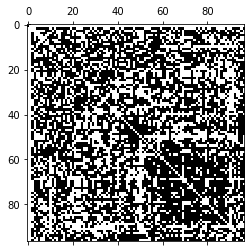

In [10]:
genotype_adjacency = get_adjacency(df_genotype.to_numpy(), 'jaccard', normalize=True)

plt.spy(genotype_adjacency, vmin=0, vmax=1)

### 3.2 Phenotype network
<a id='phenotype_net'></a>

### 3.3 Expression data network
<a id='expression_net'></a>

In [11]:
# Check for NaN
print(adrenal_female.isna().any(axis=None))
print(adrenal_male.isna().any(axis=None))
print(eye.isna().any(axis=None))

False
False
False


In [12]:
phenotypes_list = ['Adrenal_Female', 'Adrenal_Male', 'Eye']

In [13]:
# Visualization
from ipywidgets import IntSlider, interact

def plot_matrix(phenotype=phenotypes_list):
    df = open_expression_data(expression_data_folder, phenotype)
    adj = get_adjacency(df.to_numpy(), 'euclidean', normalize=True) 
    fig = plt.spy(adj, vmin=0, vmax=1)

interact(plot_matrix, n_iter=IntSlider(min=1, max=len(phenotypes_list)))

interactive(children=(Dropdown(description='phenotype', options=('Adrenal_Female', 'Adrenal_Male', 'Eye'), val…

<function __main__.plot_matrix(phenotype=['Adrenal_Female', 'Adrenal_Male', 'Eye'])>

In [ ]:
# TODO: phenotype matrix